----
## Name: 陳永承
## Student ID: 0712534
#### 2020 Introduction to Machine Learning Program Assignment #4 - Support Vector Machine & ANN
__________________

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
import keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
import json
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2020-nctu-ml-hw4/sample_submission.csv
/kaggle/input/2020-nctu-ml-hw4/recipe/train.json
/kaggle/input/2020-nctu-ml-hw4/recipe/test.json


## 1.Data Input
pd.read_json把json檔讀入，再新增一欄feature_ingredients當作訓練時的資料<br>
方便後續資料處理使用且原先資料不會被更動<br>

## 2.Data Preprocessing
Shuffle的部分一開始讀入時用sklearn中的Shuffle<br>
接者將特徵轉換成文字並且用";"分隔

In [2]:

df_train = pd.read_json('../input/2020-nctu-ml-hw4/recipe/train.json')
df_train['feature_ingredients'] = df_train['ingredients'].map(";".join)
df_train=shuffle(df_train)
# test data
df_test=pd.read_json('../input/2020-nctu-ml-hw4/recipe/test.json')
df_test['feature_ingredients'] = df_test['ingredients'].map(";".join)


print("read done")

read done


## 2.Data Preprocessing
#### data augmentation
將上面轉換成文字資料的feature用自然語言處理的方式做分類<br>
使用sklearn中CountVectorizer，用fit_transform會將原先的文字轉換成數字矩陣做為feature，用0/1的方式呈現<br>
0表示未出現，1表示有出現，而測試的資料則是用transform以training data訓練出的轉換的方式做轉換<br>
label的部分則是以sklearn的labelEncoder將各label編號，給每種類的分類一個數字<br>

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(df_train['feature_ingredients'].values)
f_name=cv.get_feature_names()
test_X=cv.transform(df_test['feature_ingredients'].values)

print("Process Done")

Process Done


In [4]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
y = enc.fit_transform(df_train.cuisine)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


## 3.Model Construction

##### Validation method
從第一次作業就存在的train_test_split，裡面參數設一設就可以自己分成0.7/0.3的訓練與測試資料

#### Support Vector Machine
svm中強大的GridSearchCV，在para_clf中設定數個不同的參數，.fit時就會自動做不同參數的訓練並找到最佳的model<br>
再將訓練最好的那段參數拿來作為本次訓練的model，best_params_可以看哪個參數最厲害

In [6]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

para_clf = {'C': [ 0.2,0.22,0.25,0.27,0.3],  
              'penalty': ['l1','l2'],
             'loss': ['hinge','squared hinge']} 

clf = GridSearchCV(LinearSVC(), para_clf , refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')


clf.fit(X_train, y_train) 
print("train done")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.4s finished


train done


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [7]:
clf.best_params_

{'C': 0.25, 'loss': 'hinge', 'penalty': 'l2'}

In [8]:
pred_temp=clf.predict(X_test)

## 3.Model Construction
#### ANN
用keras(tensorflow)架構一個3層的DNN，第一層是輸入，第三層是輸出<br>
每次用完整的data訓練，epochs 20次<br>
訓練前先將label拆成20的array(one hot encoding)<br>

<br>
選用DNN的原因是因為CNN是在圖像處理的表現上相當優秀，CNN可以在像素位置的周遭找到特徵<br>
但本次作業的資料並非圖像，因此選用DNN並猜測以DNN的模型訓練結果會較佳。

In [9]:
def defineModel(inpu,outpu):
    
    init = K.initializers.glorot_uniform(seed=1)
    model = K.models.Sequential()
    model.add(K.layers.Dense(units=20, input_dim=inpu,kernel_initializer=init, activation='relu'))
    model.add(K.layers.Dense(units=20, kernel_initializer=init, activation='relu'))
    model.add(K.layers.Dense(units=outpu, kernel_initializer=init, activation='sigmoid'))
    model.compile(loss='mean_squared_error',optimizer='rmsprop', metrics=['accuracy'])
    model.summary()
    return model

In [10]:
from keras.utils import to_categorical
Ytrain = to_categorical(y_train,20,dtype=int)
Ytest= to_categorical(y_test,20,dtype=int)
X_train2=X_train.toarray()

In [11]:
DNNmodel=defineModel(int(len(X_train2[0])),int(len(Ytrain[0])))
h=DNNmodel.fit(X_train2, Ytrain, epochs=20,shuffle=True,batch_size=1, verbose=2,validation_split=0.3) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                57220     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
Total params: 58,060
Trainable params: 58,060
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
14588/14588 - 20s - loss: 0.0341 - accuracy: 0.4572 - val_loss: 0.0303 - val_accuracy: 0.5073
Epoch 2/20
14588/14588 - 20s - loss: 0.0295 - accuracy: 0.5167 - val_loss: 0.0296 - val_accuracy: 0.5206
Epoch 3/20
14588/14588 - 19s - loss: 0.0286 - accuracy: 0.5273 - val_loss: 0.0293 - val_accuracy: 0.5261
Epoch 4/20
14588/14588 - 19s - loss: 0.0282 - accuracy: 0.5338 - va

In [12]:
X_test2=X_test.toarray()
ANN_eval=DNNmodel.evaluate(X_test2,  Ytest, verbose=0)
print("loss: ",ANN_eval[0]," accuarcy: ",ANN_eval[1])
pred_temp2=DNNmodel.predict_classes(X_test2)

loss:  0.02538333833217621  accuarcy:  0.6434568166732788


## 4.Results -Confusion matrix
Confusion matrix用scikit-learn內建的confusion_matrix產生<br>
用法為confusion_matrix(test_label,predict)<br>
再使用mlxtend.plotting中的plot_confusion_matrix產生圖表<br>

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 720000x720000 with 0 Axes>

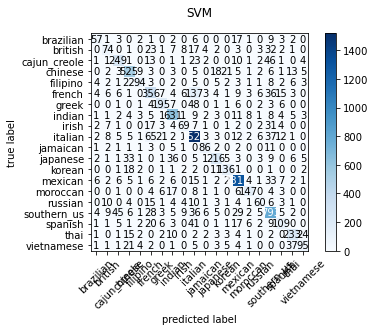

In [13]:
column_name=enc.classes_

plt.figure(figsize=(10000, 10000))
#pred_temp=enc.inverse_transform(pred_temp)
#y_str=enc.inverse_transform(y_test)

tree=confusion_matrix(y_test,pred_temp)
figuer,ax=plot_confusion_matrix(conf_mat=tree,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('SVM')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 720000x720000 with 0 Axes>

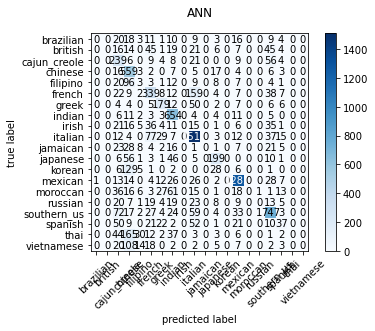

In [14]:
column_name=enc.classes_

plt.figure(figsize=(10000, 10000))
#pred_temp=enc.inverse_transform(pred_temp)
#y_str=enc.inverse_transform(y_test)

tree=confusion_matrix(y_test,pred_temp2)
figuer,ax=plot_confusion_matrix(conf_mat=tree,show_absolute=True,show_normed=False,colorbar=True,class_names=column_name)
plt.title('ANN')
plt.show

## 4.Results -accuarrcy/Sensitivity/Precision
#### SVM
accuarycy以sklearn中的.score即可計算精準度<br>
Sensitivity/Precision則是以sklearn中的classification_report就可以看到完整的資料

In [15]:
from sklearn.metrics import classification_report
print("accuarcy: ",clf.score(X_test,y_test),'\n\nreport:')
print(classification_report(y_test,pred_temp, target_names=column_name))

accuarcy:  0.7789096608082391 

report:
              precision    recall  f1-score   support

   brazilian       0.66      0.55      0.60       104
     british       0.58      0.42      0.48       178
cajun_creole       0.75      0.70      0.72       356
     chinese       0.79      0.84      0.82       622
    filipino       0.76      0.57      0.65       164
      french       0.63      0.59      0.61       607
       greek       0.78      0.71      0.74       275
      indian       0.84      0.90      0.87       703
       irish       0.68      0.46      0.55       151
     italian       0.80      0.89      0.84      1706
    jamaican       0.76      0.74      0.75       116
    japanese       0.76      0.66      0.71       328
      korean       0.76      0.76      0.76       178
     mexican       0.90      0.93      0.91      1415
    moroccan       0.82      0.74      0.78       198
     russian       0.62      0.47      0.54       128
 southern_us       0.73      0.80      0.

#### ANN
先將test資料用predict_classes從array轉換成數值資料，再用sklearn同上的方法算出accuarcy與report<br>
其中比較特殊的是這個模型預測出的資料有些是完全沒有分類到的label

In [19]:
from sklearn.metrics import accuracy_score
print("accuarcy: ",accuracy_score(pred_temp2,y_test),'\n\nreport:')
print(classification_report(y_test,pred_temp2, target_names=column_name,zero_division=1))

accuarcy:  0.6434568454046793 

report:
              precision    recall  f1-score   support

   brazilian       0.00      0.00      0.00       104
     british       0.00      0.00      0.00       178
cajun_creole       0.36      0.67      0.47       356
     chinese       0.43      0.90      0.59       622
    filipino       0.04      0.02      0.02       164
      french       0.53      0.56      0.54       607
       greek       0.59      0.65      0.62       275
      indian       0.66      0.93      0.77       703
       irish       0.00      0.00      0.00       151
     italian       0.76      0.89      0.82      1706
    jamaican       0.00      0.00      0.00       116
    japanese       0.66      0.61      0.63       328
      korean       0.00      0.00      0.00       178
     mexican       0.87      0.91      0.89      1415
    moroccan       0.00      0.00      0.00       198
     russian       0.00      0.00      0.00       128
 southern_us       0.69      0.75      0.

## 5.Comparison & Conclusion
SVM的分類效果看起來較佳，猜測是因為SVM用了各式各樣的參數去找哪個參數預測最好<br>
而ANN預測很不穩定，有些資料能很精準的預測，而有些label表現非常差，甚至沒有分到任何一筆正確的。<br>
也有可能是因為ANN本身的深度不夠深，或許多加幾層會表現更好。<br>
ANN在運算上相當耗時，並且這次GPU不能勾。

## 6.Kaggle Submission
把test的資料再拿來跑一次(用CountVectorizer轉換成原先訓練的資料形式，最前面)<br>最後預測結果用sklearn中inverse_transform轉換回原資料<br>
用to_csv即可儲存檔案
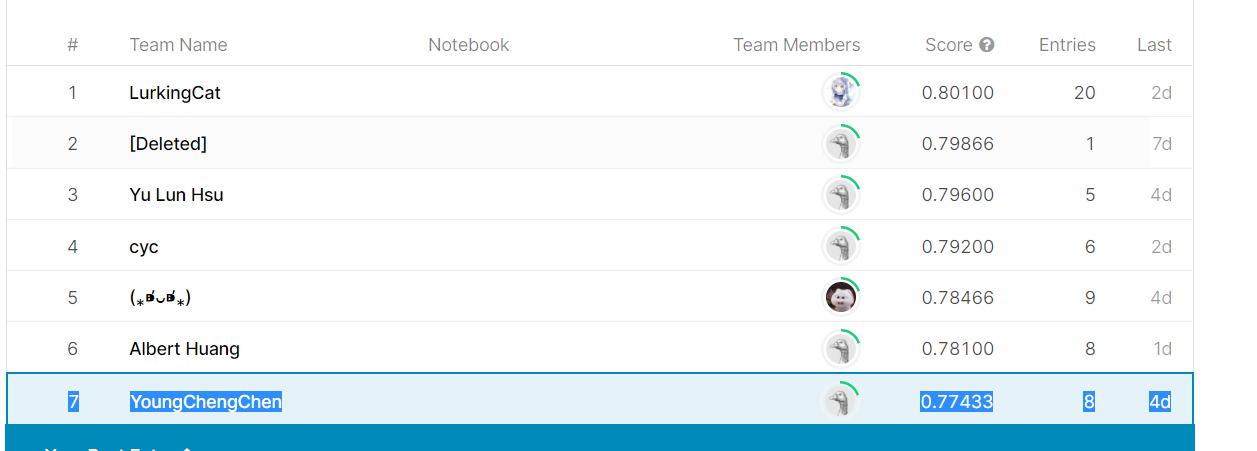

In [17]:
pred = clf.predict(test_X)
pred=enc.inverse_transform(pred)

In [18]:
submission = pd.DataFrame({'id':df_test['id']})
submission['Category'] = pred
submission.to_csv('submit.csv', index=False)
print("Save Done")

Save Done
